<a href="https://colab.research.google.com/github/shane-harris/Network_Intrusion_Detector/blob/master/Network_Intrusion_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import csv
import io
import requests
import os
import collections
import random
import time
import sklearn

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.feature_extraction.text as sk_text

from sklearn import metrics
from sklearn import preprocessing 
from sklearn import svm, datasets
from sklearn.linear_model import Lasso
from sklearn.metrics import roc_curve, auc
from matplotlib.pyplot import figure, show
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# Simple function to evaluate the coefficients of a regression

%matplotlib inline    
from IPython.display import display   

def report_coef(names,coef,intercept):
    r = pd.DataFrame( { 'coef': coef, 'positive': coef>=0  }, index = names )
    r = r.sort_values(by=['coef'])
    display(r)
    print("Intercept: {}".format(intercept))
    r['coef'].plot(kind='barh', color=r['positive'].map({True: 'b', False: 'r'}))

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

In [ ]:
# Creating Directories for best weights to be saved
if not os.path.exists('/content/drive/My Drive/CSC 180/Assignment 2/best_weights_dense'):
  os.mkdir('/content/drive/My Drive/CSC 180/Assignment 2/best_weights_dense')
if not os.path.exists('/content/drive/My Drive/CSC 180/Assignment 2/best_weights_all_features'):
  os.mkdir('/content/drive/My Drive/CSC 180/Assignment 2/best_weights_all_features') 

In [ ]:
# Read in csv file
networkTraffic = pd.read_csv("/content/drive/My Drive/CSC 180/Assignment 2/data/network_intrusion_data.csv")

In [ ]:
# lable each column //names provided by professor
networkTraffic.columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'outcome']
networkTraffic.shape

(494020, 42)

In [ ]:
networkTraffic.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,29,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,219,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,39,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,49,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,59,59,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [ ]:
# Removing duplicate rows. Apparently there are ALOT of duplicates
networkTraffic_reduced = networkTraffic.drop_duplicates()
networkTraffic_reduced.shape

(145585, 42)

In [ ]:
# Seperating out Normal Traffic and Attack Traffic
networkNormal = networkTraffic_reduced[networkTraffic_reduced['outcome']=='normal.']
networkAttack = networkTraffic_reduced[networkTraffic_reduced['outcome']!='normal.']

In [ ]:
networkNormal.shape

(87831, 42)

In [ ]:
networkAttack.shape

(57754, 42)

In [ ]:
# Shuffling Normal network traffic data
network_normal_shuffle = networkNormal.sample(frac=1).reset_index(drop=True)

In [ ]:
network_normal_shuffle.shape

(87831, 42)

In [ ]:
# Reducing number of Normal network traffic records
# to match number of Attack network Traffic records
network_normal_shuffle_reduced = network_normal_shuffle.head(networkAttack.shape[0])
network_normal_shuffle_reduced.shape

(57754, 42)

In [ ]:
# Recombining reduced Normal network traffic to 
# Attack traffic then shuffling dataframe
networkTraffic_reduced_shuffle = pd.concat([network_normal_shuffle_reduced,networkAttack], axis=0)
networkTraffic_reduced_shuffle = networkTraffic_reduced_shuffle.sample(frac=1).reset_index(drop=True)
networkTraffic_reduced_shuffle.shape

(115508, 42)

In [ ]:
# Saving Results to csv file
networkTraffic_reduced_shuffle.to_csv(r'/content/drive/My Drive/CSC 180/Assignment 2/data/network_Traffic_reduced_shuffled.csv')

In [ ]:
# Save data as new file abscent duplicate rows
networkTraffic_reduced.to_csv(r'/content/drive/My Drive/CSC 180/Assignment 2/data/network_Traffic.csv')

In [ ]:
# Segmenting out the protocol type for later encoding
protocol_type = networkTraffic_reduced_shuffle['protocol_type']
protocol_type.shape

(115508,)

In [ ]:
# Segmenting out services for later encoding
service = networkTraffic_reduced_shuffle['service']
service.shape

(115508,)

In [ ]:
# Segmenting out flags for later encoding
flags = networkTraffic_reduced_shuffle['flag']
flags.shape

(115508,)

In [ ]:
# Segmenting out outcome for later encoding
outcome = networkTraffic_reduced_shuffle['outcome']
outcome.shape

(115508,)

In [ ]:
# There are 4 verctorizers because of the 4 One Hot encoded columns
vectorizer1 = sk_text.CountVectorizer(min_df=0)
vectorizer2 = sk_text.CountVectorizer(min_df=0)
vectorizer3 = sk_text.CountVectorizer(min_df=0)
vectorizer4 = sk_text.CountVectorizer(min_df=0)

In [ ]:
protocol_type_matrix = vectorizer1.fit_transform(protocol_type)

In [ ]:
service_matrix = vectorizer2.fit_transform(service)

In [ ]:
flags_matrix = vectorizer3.fit_transform(flags)

In [ ]:
outcome_matrix = vectorizer4.fit_transform(outcome.values.astype('U'))

In [ ]:
print(protocol_type_matrix.toarray())

[[0 1 0]
 [0 1 0]
 [0 1 0]
 ...
 [0 1 0]
 [0 0 1]
 [0 1 0]]


In [ ]:
print(flags_matrix.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
print(service_matrix.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
protocol_type_matrix.shape

(115508, 3)

In [ ]:
service_matrix.shape

(115508, 65)

In [ ]:
flags_matrix.shape

(115508, 11)

In [ ]:
outcome_matrix.shape

(115508, 23)

In [ ]:
print(vectorizer1.get_feature_names())

['icmp', 'tcp', 'udp']


In [ ]:
print(vectorizer2.get_feature_names())

['auth', 'bgp', 'courier', 'csnet_ns', 'ctf', 'daytime', 'discard', 'domain', 'domain_u', 'echo', 'eco_i', 'ecr_i', 'efs', 'exec', 'finger', 'ftp', 'ftp_data', 'gopher', 'hostnames', 'http', 'http_443', 'imap4', 'irc', 'iso_tsap', 'klogin', 'kshell', 'ldap', 'link', 'login', 'mtp', 'name', 'netbios_dgm', 'netbios_ns', 'netbios_ssn', 'netstat', 'nnsp', 'nntp', 'ntp_u', 'other', 'pm_dump', 'pop_2', 'pop_3', 'printer', 'private', 'red_i', 'remote_job', 'rje', 'shell', 'smtp', 'sql_net', 'ssh', 'sunrpc', 'supdup', 'systat', 'telnet', 'tim_i', 'time', 'urh_i', 'urp_i', 'uucp', 'uucp_path', 'vmnet', 'whois', 'x11', 'z39_50']


In [ ]:
print(vectorizer3.get_feature_names())

['oth', 'rej', 'rsto', 'rstos0', 'rstr', 's0', 's1', 's2', 's3', 'sf', 'sh']


In [ ]:
print(vectorizer4.get_feature_names())

['back', 'buffer_overflow', 'ftp_write', 'guess_passwd', 'imap', 'ipsweep', 'land', 'loadmodule', 'multihop', 'neptune', 'nmap', 'normal', 'perl', 'phf', 'pod', 'portsweep', 'rootkit', 'satan', 'smurf', 'spy', 'teardrop', 'warezclient', 'warezmaster']


In [ ]:
networkTraffic_Normalized = networkTraffic_reduced_shuffle

In [ ]:
del networkTraffic_Normalized['protocol_type']
del networkTraffic_Normalized['service']
del networkTraffic_Normalized['flag']
del networkTraffic_Normalized['outcome']

In [ ]:
# Transforming the column's protocol_type, service, and flag from
# a matrix that had been One Hot Encoded back to a dataframe
# these will then be appended to the network traffic data

protocol_type_vectorized = pd.DataFrame(protocol_type_matrix.todense(), columns=vectorizer1.get_feature_names())
service_vectorized = pd.DataFrame(service_matrix.todense(), columns=vectorizer2.get_feature_names())
flags_vectorized = pd.DataFrame(flags_matrix.todense(), columns=vectorizer3.get_feature_names())
outcome_vectorized = pd.DataFrame(outcome_matrix.todense(), columns=vectorizer4.get_feature_names())

In [ ]:
protocol_type_vectorized.shape

(115508, 3)

In [ ]:
service_vectorized.shape

(115508, 65)

In [ ]:
flags_vectorized.shape

(115508, 11)

In [ ]:
outcome_vectorized.shape

(115508, 23)

In [ ]:
# Concatinating the One Hot Encoded Columns into one dataframe
# This data frame will be later appended to the dataset
networkTraffic_Normalized_vectorized = pd.concat([protocol_type_vectorized, service_vectorized, flags_vectorized], axis=1)
networkTraffic_Normalized_vectorized.reset_index(drop=True)
networkTraffic_Normalized_vectorized.shape

(115508, 79)

In [ ]:
outcome_vectorized.head()

,back,buffer_overflow,ftp_write,guess_passwd,imap,ipsweep,land,loadmodule,multihop,neptune,nmap,normal,perl,phf,pod,portsweep,rootkit,satan,smurf,spy,teardrop,warezclient,warezmaster
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# outcome_vectorized.to_csv(r'outcome_vectorized.csv')

In [ ]:
# Extracted just the column labled normal normal= "1" all attacks="0"
outcome_normal_vectorized = outcome_vectorized['normal']
outcome_attack_vectorized = outcome_vectorized['normal'].replace({1:0,0:1})
outcome_attack_vectorized.name = 'attack'

In [ ]:
# Concatinating Normal and attack Columns to dataframe
networkTraffic_Normalized_vectorized1 = pd.concat([networkTraffic_Normalized_vectorized, outcome_normal_vectorized, outcome_attack_vectorized], axis=1)

# Concatinating All Attack types to dataframe to classify individual attacks
networkTraffic_Normalized_vectorized2 = pd.concat([networkTraffic_Normalized_vectorized, outcome_vectorized], axis=1)

In [ ]:
networkTraffic_Normalized_vectorized1.shape

(115508, 81)

In [ ]:
# networkTraffic_Normalized.to_csv(r'network_Traffic_removed_columns.csv')

In [ ]:
networkTraffic_Normalized_vectorized.to_csv(r'/content/drive/My Drive/CSC 180/Assignment 2/data/network_Traffic_removed_columns_vectorized.csv')

In [ ]:
#*** Doing this above instead of below allows the final matrix to have ***#
#*** Column names for the values that are descrete ***#

# Final Normalization then shuffle of all values before training
network_traffic_values = networkTraffic_Normalized.values
min_max_scaler = preprocessing.MinMaxScaler()
network_traffic_scaled = min_max_scaler.fit_transform(network_traffic_values)
networkTraffic_Normalized_scaled = pd.DataFrame(network_traffic_scaled)

In [ ]:
# All the data that is not One Hot Encoded is now appended to the dataframe
# 42 -1 - 1- 1 - 1 + 3 + 65 + 11 + 1 = 118 // Verifying the correct
# number of columns after appending One Hot Encoded columns to dataset
networkTraffic_Normalized_vectorized_encoded_scaled = pd.concat([networkTraffic_Normalized_scaled, networkTraffic_Normalized_vectorized1], axis=1)

# All individual attacks
networkTraffic_Normalized_vectorized_encoded_scaled1 = pd.concat([networkTraffic_Normalized_scaled, networkTraffic_Normalized_vectorized2], axis=1)

In [ ]:
networkTraffic_Normalized_vectorized_encoded_scaled.to_csv(r'/content/drive/My Drive/CSC 180/Assignment 2/data/networkTraffic_Normalized_vectorized_encoded.csv')
networkTraffic_Normalized_vectorized_encoded_scaled1.to_csv(r'/content/drive/My Drive/CSC 180/Assignment 2/data/networkTraffic_Normalized_vectorized_encoded_attacks.csv')

In [ ]:
networkTraffic_Normalized_vectorized_encoded_scaled['attack'].head()

0    1
1    0
2    1
3    1
4    1
Name: attack, dtype: int64

In [ ]:
networkTraffic_Normalized_vectorized_encoded_scaled.shape

(115508, 119)

In [ ]:
# adding column names to all the columns again

networkTraffic_Normalized_vectorized_encoded_scaled_column_names = networkTraffic_Normalized_vectorized_encoded_scaled.rename(columns={
    0: 'duration',
    1: 'src_bytes',
    2: 'dst_bytes',
    3: 'land',
    4: 'wrong_fragment',
    5: 'urgent',
    6: 'hot',
    7: 'num_failed_logins',
    8: 'logged_in',
    9: 'num_compromised',
    10: 'root_shell',
    11: 'su_attempted',
    12: 'num_root',
    13: 'num_file_creations',
    14: 'num_shells',
    15: 'num_access_files',
    16: 'num_outbound_cmds',
    17: 'is_host_login',
    18: 'is_guest_login',
    19: 'count',
    20: 'srv_count',
    21: 'serror_rate',
    22: 'srv_serror_rate',
    23: 'rerror_rate',
    24: 'srv_rerror_rate',
    25: 'same_srv_rate',
    26: 'diff_srv_rate',
    27: 'srv_diff_host_rate',
    28: 'dst_host_count',
    29: 'dst_host_srv_count',
    30: 'dst_host_same_srv_rate',
    31: 'dst_host_diff_srv_rate',
    32: 'dst_host_same_src_port_rate',
    33: 'dst_host_srv_diff_host_rate',
    34: 'dst_host_serror_rate',
    35: 'dst_host_srv_serror_rate',
    36: 'dst_host_rerror_rate',
    37: 'dst_host_srv_rerror_rate'
    })

# Adding column names to all the columns again
networkTraffic_Normalized_vectorized_encoded_scaled_column_names1 = networkTraffic_Normalized_vectorized_encoded_scaled1.rename(columns={0: 'duration',1: 'src_bytes',2: 'dst_bytes',3: 'land',4: 'wrong_fragment',5: 'urgent',6: 'hot',7: 'num_failed_logins',8: 'logged_in',9: 'num_compromised',10: 'root_shell',11: 'su_attempted',12: 'num_root',13: 'num_file_creations',14: 'num_shells',15: 'num_access_files',16: 'num_outbound_cmds',17: 'is_host_login',18: 'is_guest_login',19: 'count',20: 'srv_count',21: 'serror_rate',22: 'srv_serror_rate',23: 'rerror_rate',24: 'srv_rerror_rate',25: 'same_srv_rate',26: 'diff_srv_rate',27: 'srv_diff_host_rate',28: 'dst_host_count',29: 'dst_host_srv_count',30: 'dst_host_same_srv_rate',31: 'dst_host_diff_srv_rate',32: 'dst_host_same_src_port_rate',33: 'dst_host_srv_diff_host_rate',34: 'dst_host_serror_rate',35: 'dst_host_srv_serror_rate',36: 'dst_host_rerror_rate',37: 'dst_host_srv_rerror_rate'})


In [ ]:
networkTraffic_Normalized_vectorized_encoded_scaled_column_names.columns

Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       ...
       'rstos0', 'rstr', 's0', 's1', 's2', 's3', 'sf', 'sh', 'normal',
       'attack'],
      dtype='object', length=119)

In [ ]:
networkTraffic_Normalized_vectorized_encoded_scaled_column_names1.columns

Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       ...
       'phf', 'pod', 'portsweep', 'rootkit', 'satan', 'smurf', 'spy',
       'teardrop', 'warezclient', 'warezmaster'],
      dtype='object', length=140)

In [ ]:
# Spliiting with column names
x_network1 = networkTraffic_Normalized_vectorized_encoded_scaled_column_names.loc[:, networkTraffic_Normalized_vectorized_encoded_scaled_column_names.columns != 'normal']
y_network1 = networkTraffic_Normalized_vectorized_encoded_scaled_column_names['normal']
#y_network1.reset_index()
# Adding additional column to y so one is an attack column and another is a normal column
#y_network2 = pd.concat([y_network1, y_network1.replace({1:0,0:1}).rename(columns={0:'Attack'})], axis=1)
#y_network2.head()
y_network2 = pd.concat([y_network1, y_network1.replace({1:0,0:1}).reset_index().rename(columns={"normal":"Attack"})], axis=1)
#.reset_index().rename(columns={0:'Attack'})], axis=1)
y_network2 = y_network2.drop(columns={'index'})
y_network2.head()

,normal,Attack
0,0,1
1,1,0
2,0,1
3,0,1
4,0,1


In [ ]:
#y_network1.head()
x_network1.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,icmp,tcp,...,ntp_u,other,pm_dump,pop_2,pop_3,printer,private,red_i,remote_job,rje,shell,smtp,sql_net,ssh,sunrpc,supdup,systat,telnet,tim_i,time,urh_i,urp_i,uucp,uucp_path,vmnet,whois,x11,z39_50,oth,rej,rsto,rstos0,rstr,s0,s1,s2,s3,sf,sh,attack
0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.264188,0.013699,1.0,1.0,0.0,0.0,0.05,0.06,0.0,1.000000,0.054902,0.05,0.07,0.00,0.0,1.0,1.0,0.0,0.0,0,1,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,0.0,2.769062e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003914,0.003914,0.0,0.0,0.0,0.0,1.00,0.00,0.0,0.745098,0.203922,0.27,0.03,0.27,0.0,0.0,0.0,0.0,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.508806,0.013699,0.0,0.0,1.0,1.0,0.03,0.07,0.0,1.000000,0.027451,0.03,0.07,0.00,0.0,0.0,0.0,1.0,1.0,0,1,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.328767,0.015656,0.0,0.0,1.0,1.0,0.05,0.07,0.0,1.000000,0.031373,0.03,0.08,0.00,0.0,0.0,0.0,1.0,1.0,0,1,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.307241,0.011742,1.0,1.0,0.0,0.0,0.04,0.07,0.0,1.000000,0.023529,0.02,0.07,0.00,0.0,1.0,1.0,0.0,0.0,0,1,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [ ]:
y_network1.head()

0    0
1    1
2    0
3    0
4    0
Name: normal, dtype: int64

In [ ]:
networkTraffic_Normalized_vectorized_encoded_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,icmp,tcp,...,other,pm_dump,pop_2,pop_3,printer,private,red_i,remote_job,rje,shell,smtp,sql_net,ssh,sunrpc,supdup,systat,telnet,tim_i,time,urh_i,urp_i,uucp,uucp_path,vmnet,whois,x11,z39_50,oth,rej,rsto,rstos0,rstr,s0,s1,s2,s3,sf,sh,normal,attack
0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.264188,0.013699,1.0,1.0,0.0,0.0,0.05,0.06,0.0,1.000000,0.054902,0.05,0.07,0.00,0.0,1.0,1.0,0.0,0.0,0,1,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,0.0,2.769062e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003914,0.003914,0.0,0.0,0.0,0.0,1.00,0.00,0.0,0.745098,0.203922,0.27,0.03,0.27,0.0,0.0,0.0,0.0,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.508806,0.013699,0.0,0.0,1.0,1.0,0.03,0.07,0.0,1.000000,0.027451,0.03,0.07,0.00,0.0,0.0,0.0,1.0,1.0,0,1,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.328767,0.015656,0.0,0.0,1.0,1.0,0.05,0.07,0.0,1.000000,0.031373,0.03,0.08,0.00,0.0,0.0,0.0,1.0,1.0,0,1,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.307241,0.011742,1.0,1.0,0.0,0.0,0.04,0.07,0.0,1.000000,0.023529,0.02,0.07,0.00,0.0,1.0,1.0,0.0,0.0,0,1,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [ ]:
# Final Value Shiffle before training
networkTraffic_Normalized_vectorized_encoded_scaled = networkTraffic_Normalized_vectorized_encoded_scaled.sample(frac=1).reset_index(drop=True)
# Shuffling of dataframe containgning individual attacks
networkTraffic_Normalized_vectorized_encoded_scaled1 = networkTraffic_Normalized_vectorized_encoded_scaled1.sample(frac=1).reset_index(drop=True)

In [ ]:
# Copy all columns except for Ground Truth column
# outcome column name changed to normal due to removing from 
# one hot encoded outcome column
temp_df = networkTraffic_Normalized_vectorized_encoded_scaled.loc[:, networkTraffic_Normalized_vectorized_encoded_scaled.columns != 'normal']
x_network = temp_df.loc[:, temp_df.columns != 'attack']
x_network.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,icmp,tcp,...,nntp,ntp_u,other,pm_dump,pop_2,pop_3,printer,private,red_i,remote_job,rje,shell,smtp,sql_net,ssh,sunrpc,supdup,systat,telnet,tim_i,time,urh_i,urp_i,uucp,uucp_path,vmnet,whois,x11,z39_50,oth,rej,rsto,rstos0,rstr,s0,s1,s2,s3,sf,sh
0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.528376,0.021526,1.0,1.0,0.0,0.0,0.04,0.06,0.0,1.000000,0.039216,0.04,0.06,0.00,0.00,1.00,1.00,0.00,0.0,0,1,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0.0,0.000000e+00,7.758752e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.001957,0.0,0.0,0.0,0.0,1.00,0.00,0.0,0.101961,0.101961,1.00,0.00,0.04,0.00,0.12,0.12,0.00,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0.0,1.514331e-07,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003914,0.003914,0.0,0.0,0.0,0.0,1.00,0.00,0.0,0.745098,0.737255,0.99,0.01,0.01,0.00,0.00,0.00,0.00,0.0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0.0,1.515773e-06,6.284589e-05,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.007828,0.0,0.0,0.0,0.0,1.00,0.00,1.0,0.772549,0.490196,0.63,0.02,0.01,0.00,0.00,0.00,0.01,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0.0,3.720927e-07,7.060465e-05,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.001957,0.0,0.0,0.0,0.0,1.00,0.00,0.0,0.003922,1.000000,1.00,0.00,1.00,0.03,0.00,0.00,0.00,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
#x_network1 = networkTraffic_Normalized_vectorized_encoded_scaled1.loc[:, networkTraffic_Normalized_vectorized_encoded_scaled1.columns != 'back', 'buffer_overflow', 'ftp_write', 'guess_passwd', 'imap', 'ipsweep', 'land', 'loadmodule', 'multihop', 'neptune', 'nmap', 'normal', 'perl', 'phf', 'pod', 'portsweep', 'rootkit', 'satan', 'smurf', 'spy', 'teardrop', 'warezclient', 'warezmaster']
x_network3 = networkTraffic_Normalized_vectorized_encoded_scaled1[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,'icmp','tcp','udp','auth','bgp','courier','csnet_ns','ctf','daytime','discard','domain','domain_u','echo','eco_i','ecr_i','efs','exec','finger','ftp','ftp_data','gopher','hostnames','http','http_443','imap4','irc','iso_tsap','klogin','kshell','ldap','link','login','mtp','name','netbios_dgm','netbios_ns','netbios_ssn','netstat','nnsp','nntp','ntp_u','other','pm_dump','pop_2','pop_3','printer','private','remote_job','rje','shell','smtp','sql_net','ssh','sunrpc','supdup','systat','telnet','tim_i','time','urh_i','urp_i','uucp','uucp_path','vmnet','whois','x11','z39_50','oth','rej','rsto','rstos0','rstr','s0','s1','s2','s3','sf','sh']]
x_network3.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,icmp,tcp,...,nnsp,nntp,ntp_u,other,pm_dump,pop_2,pop_3,printer,private,remote_job,rje,shell,smtp,sql_net,ssh,sunrpc,supdup,systat,telnet,tim_i,time,urh_i,urp_i,uucp,uucp_path,vmnet,whois,x11,z39_50,oth,rej,rsto,rstos0,rstr,s0,s1,s2,s3,sf,sh
0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.289628,0.011742,0.0,0.0,1.0,1.0,0.04,0.06,0.0,1.000000,0.023529,0.02,0.05,0.0,0.00,0.0,0.0,1.0,1.0,0,1,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.483366,0.019569,1.0,1.0,0.0,0.0,0.04,0.07,0.0,1.000000,0.039216,0.04,0.07,0.0,0.00,1.0,1.0,0.0,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.426614,0.017613,1.0,1.0,0.0,0.0,0.04,0.05,0.0,1.000000,0.035294,0.04,0.06,0.0,0.00,1.0,1.0,0.0,0.0,0,1,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0.0,8.509096e-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.021526,0.021526,0.0,0.0,0.0,0.0,1.00,0.00,0.0,0.180392,0.247059,0.50,0.07,0.5,0.05,0.0,0.0,0.0,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.248532,0.045010,1.0,1.0,0.0,0.0,0.18,0.06,0.0,1.000000,0.090196,0.09,0.05,0.0,0.00,1.0,1.0,0.0,0.0,0,1,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
# Copy just Ground Truth Column
y_network = networkTraffic_Normalized_vectorized_encoded_scaled['normal']
y_network.shape

(115508,)

In [ ]:
#y_network2.shape

In [ ]:
# Copy just Ground Truth Column + individual attacks
y_network3 = networkTraffic_Normalized_vectorized_encoded_scaled1[['back', 'buffer_overflow', 'ftp_write', 'guess_passwd', 'imap', 'ipsweep', 'land', 'loadmodule', 'multihop', 'neptune', 'nmap', 'normal', 'perl', 'phf', 'pod', 'portsweep', 'rootkit', 'satan', 'smurf', 'spy', 'teardrop', 'warezclient', 'warezmaster']]
y_network3.shape

(115508, 23)

In [ ]:
# Copy just Ground Truth Column + individual attacks
y_network3 = networkTraffic_Normalized_vectorized_encoded_scaled1[['back', 'buffer_overflow', 'ftp_write', 'guess_passwd', 'imap', 'ipsweep', 'land', 'loadmodule', 'multihop', 'neptune', 'nmap', 'normal', 'perl', 'phf', 'pod', 'portsweep', 'rootkit', 'satan', 'smurf', 'spy', 'teardrop', 'warezclient', 'warezmaster']]
y_network3.shape

(115508, 23)

In [ ]:
#Split data into Train/Test for CNN
x_network_train, x_network_test, y_network_train, y_network_test = train_test_split(x_network, y_network, test_size=0.20, random_state=42)
#Split data into Train/Test for Dense Neural Network
x_network_train_dense, x_network_test_dense, y_network_train_dense, y_network_test_dense = train_test_split(x_network, y_network2, test_size=0.20, random_state=42)
# Split data for Dense Neural Network individual attacks
x_network_train_dense_attacks, x_network_test_dense_attacks, y_network_train_dense_attacks, y_network_test_dense_attacks = train_test_split(x_network3, y_network3, test_size=0.20, random_state=42)

In [ ]:
x_network.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,icmp,tcp,...,nntp,ntp_u,other,pm_dump,pop_2,pop_3,printer,private,red_i,remote_job,rje,shell,smtp,sql_net,ssh,sunrpc,supdup,systat,telnet,tim_i,time,urh_i,urp_i,uucp,uucp_path,vmnet,whois,x11,z39_50,oth,rej,rsto,rstos0,rstr,s0,s1,s2,s3,sf,sh
0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.528376,0.021526,1.0,1.0,0.0,0.0,0.04,0.06,0.0,1.000000,0.039216,0.04,0.06,0.00,0.00,1.00,1.00,0.00,0.0,0,1,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0.0,0.000000e+00,7.758752e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.001957,0.0,0.0,0.0,0.0,1.00,0.00,0.0,0.101961,0.101961,1.00,0.00,0.04,0.00,0.12,0.12,0.00,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0.0,1.514331e-07,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003914,0.003914,0.0,0.0,0.0,0.0,1.00,0.00,0.0,0.745098,0.737255,0.99,0.01,0.01,0.00,0.00,0.00,0.00,0.0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0.0,1.515773e-06,6.284589e-05,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.007828,0.0,0.0,0.0,0.0,1.00,0.00,1.0,0.772549,0.490196,0.63,0.02,0.01,0.00,0.00,0.00,0.01,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0.0,3.720927e-07,7.060465e-05,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.001957,0.0,0.0,0.0,0.0,1.00,0.00,0.0,0.003922,1.000000,1.00,0.00,1.00,0.03,0.00,0.00,0.00,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
# Converting all to numpy arrays for model to train from
# Reshaping the data from 2D 4D for CNN model
# Convert dataframe to numpy array then reshape
# via the number of records and the number of features per record

x_train_cnn = x_network_train.to_numpy().reshape((x_network_train.shape[0], 1, x_network.shape[1], 1))
x_test_cnn = x_network_test.to_numpy().reshape((x_network_test.shape[0], 1, x_network.shape[1], 1))
y_train_cnn = tf.keras.utils.to_categorical(y_network_train.to_numpy(), 2)
y_test_cnn = tf.keras.utils.to_categorical(y_network_test.to_numpy(), 2)

# These X's and Y's have 2 columns 1 for normal activity and 1 for Attacks
x_train_dense = x_network_train_dense.to_numpy()
x_test_dense = x_network_test_dense.to_numpy()
y_train_dense = tf.keras.utils.to_categorical(y_network_train.to_numpy(), 2)
y_test_dense = tf.keras.utils.to_categorical(y_network_test.to_numpy(), 2)

In [ ]:
x_train_cnn.shape

(92406, 1, 117, 1)

In [ ]:
y_test_cnn.shape

(23102, 2)

In [ ]:
x_network_train.shape

(92406, 117)

In [ ]:
batch_size = 128

In [ ]:
# define a CNN 
# This will be the first training without removing any features

start_time = time.time()

cnn = Sequential()

cnn.add(Conv2D(32, kernel_size=(1, 2), strides=(1, 1), padding='same',
                 activation='relu',
                 input_shape=(x_train_cnn.shape[1:])))
cnn.add(Dropout(0.1))

cnn.add(MaxPooling2D(pool_size=(1,2)))

cnn.add(Conv2D(64, kernel_size=(1, 2), strides=(1, 1), padding='same',
                  activation='relu'))
cnn.add(MaxPooling2D(pool_size=(1,2)))
    
cnn.add(Flatten())
cnn.add(Dense(128, activation="relu"))
cnn.add(Dense(2, activation="softmax"))

# define optimizer and objective, compile cnn

cnn.compile(loss="categorical_crossentropy", optimizer="adam")

# Defining check and monitor for early stopping and svaing best model
checkpointer = ModelCheckpoint(filepath="/content/drive/My Drive/CSC 180/Assignment 2/best_weights_all_features/best_weights_all_features.hdf5", verbose=2, save_best_only=True)
monitor = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=2, mode='auto')

cnn.fit(x_train_cnn, y_train_cnn,     
          batch_size=batch_size,
          epochs=10,
          verbose=2,
          callbacks=[monitor,checkpointer],
          validation_data=(x_test_cnn, y_test_cnn))

# Load weights from best model
cnn.load_weights('/content/drive/My Drive/CSC 180/Assignment 2/best_weights_all_features/best_weights_all_features.hdf5')

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Epoch 1/10

Epoch 00001: val_loss improved from inf to 0.02387, saving model to /content/drive/My Drive/CSC 180/Assignment 2/best_weights_all_features/best_weights_all_features.hdf5
722/722 - 3s - loss: 0.0503 - val_loss: 0.0239
Epoch 2/10

Epoch 00002: val_loss improved from 0.02387 to 0.01257, saving model to /content/drive/My Drive/CSC 180/Assignment 2/best_weights_all_features/best_weights_all_features.hdf5
722/722 - 2s - loss: 0.0172 - val_loss: 0.0126
Epoch 3/10

Epoch 00003: val_loss improved from 0.01257 to 0.00983, saving model to /content/drive/My Drive/CSC 180/Assignment 2/best_weights_all_features/best_weights_all_features.hdf5
722/722 - 2s - loss: 0.0106 - val_loss: 0.0098
Epoch 4/10

Epoch 00004: val_loss improved from 0.00983 to 0.00908, saving model to /content/drive/My Drive/CSC 180/Assignment 2/best_weights_all_features/best_weights_all_features.hdf5
722/722 - 2s - loss: 0.0092 - val_loss: 0.0091
Epoch 5/10

Epoch 00005: val_loss did not improve from 0.00908
722/722 -

In [ ]:
# evaluate() computes the loss and accuracy
score = cnn.evaluate(x_test_cnn, y_test_cnn, verbose=0)
score

0.008192112669348717

In [ ]:
cnn.metrics_names

['loss']

In [ ]:
# print('Test loss: {}'.format(score[0]))
# print('Test accuracy: {}'.format(score[1]))
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1, 117, 32)        96        
_________________________________________________________________
dropout (Dropout)            (None, 1, 117, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 58, 32)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 58, 64)         4160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 29, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1856)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               2

In [ ]:
# Print Accuracy and F1 Score for CNN
y_true_cnn = np.argmax(y_test_cnn,axis=1)
pred_cnn = cnn.predict(x_test_cnn)
pred_cnn = np.argmax(pred_cnn,axis=1)
score_cnn = metrics.accuracy_score(y_true_cnn, pred_cnn)
print('Accuracy: {}'.format(score))
f1 = metrics.f1_score(y_true_cnn, pred_cnn, average='weighted')
print('Averaged F1: {}'.format(f1))   
print(metrics.classification_report(y_true_cnn, pred_cnn))

Accuracy: 0.008192112669348717
Averaged F1: 0.9977923986162704
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11562
           1       1.00      1.00      1.00     11540

    accuracy                           1.00     23102
   macro avg       1.00      1.00      1.00     23102
weighted avg       1.00      1.00      1.00     23102



In [ ]:
# Encoding the outcome column from the original dataframe
outcome_final = encode_text_index(networkTraffic_Normalized_vectorized_encoded_scaled,'normal')

[[11538    24]
 [   27 11513]]
Plotting confusion matrix


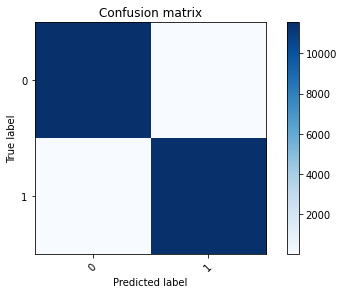

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11562
           1       1.00      1.00      1.00     11540

    accuracy                           1.00     23102
   macro avg       1.00      1.00      1.00     23102
weighted avg       1.00      1.00      1.00     23102



In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_true_cnn, pred_cnn)
print(cm)
print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(cm, outcome_final)
plt.show()
print(classification_report(y_true_cnn, pred_cnn))

In [ ]:
# This Model is built for a y with 2 columns 1 for normal 
# one for an attack. 

model = Sequential()

model.add(Dense(64, input_dim=x_network.shape[1], activation='relu')) 
model.add(Dropout(0.1))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(y_network_train_dense.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='sgd')

#Stop early if the epochs start to increase
monitor = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

#Saving the best model
checkpointer = ModelCheckpoint(filepath="/content/drive/My Drive/CSC 180/Assignment 2/best_weights_dense/best_weights_dense.hdf5", verbose=2, save_best_only=True)

model.fit(x_train_dense,y_train_dense,validation_data=(x_test_dense,y_test_dense),callbacks=[monitor,checkpointer],verbose=2,epochs=10)

#load weights from best model
model.load_weights('/content/drive/My Drive/CSC 180/Assignment 2/best_weights_dense/best_weights_dense.hdf5')

Epoch 1/10

Epoch 00001: val_loss improved from inf to 0.10294, saving model to /content/drive/My Drive/CSC 180/Assignment 2/best_weights_dense/best_weights_dense.hdf5
2888/2888 - 7s - loss: 0.1837 - accuracy: 0.9590 - val_loss: 0.1029 - val_accuracy: 0.9687
Epoch 2/10

Epoch 00002: val_loss improved from 0.10294 to 0.07998, saving model to /content/drive/My Drive/CSC 180/Assignment 2/best_weights_dense/best_weights_dense.hdf5
2888/2888 - 7s - loss: 0.0887 - accuracy: 0.9746 - val_loss: 0.0800 - val_accuracy: 0.9768
Epoch 3/10

Epoch 00003: val_loss improved from 0.07998 to 0.06741, saving model to /content/drive/My Drive/CSC 180/Assignment 2/best_weights_dense/best_weights_dense.hdf5
2888/2888 - 7s - loss: 0.0717 - accuracy: 0.9800 - val_loss: 0.0674 - val_accuracy: 0.9800
Epoch 4/10

Epoch 00004: val_loss improved from 0.06741 to 0.05933, saving model to /content/drive/My Drive/CSC 180/Assignment 2/best_weights_dense/best_weights_dense.hdf5
2888/2888 - 7s - loss: 0.0614 - accuracy: 0

In [ ]:
# evaluate() computes the loss and accuracy
score_dense = model.evaluate(x_test_dense, y_test_dense, verbose=0)
score_dense

[0.0408017672598362, 0.9856289625167847]

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                7552      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 130       
Total params: 11,842
Trainable params: 11,842
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Print Accuracy and F1 Score for Dense Neural Network
y_true_dense = np.argmax(y_test_dense,axis=1)
pred_dense = model.predict(x_test_dense)
pred_dense = np.argmax(pred_dense,axis=1)
score_dense = metrics.accuracy_score(y_true_dense, pred_dense)
print('Accuracy: {}'.format(score))
f1_dense = metrics.f1_score(y_true_dense, pred_dense, average='weighted')
print('Averaged F1: {}'.format(f1_dense))           
print(metrics.classification_report(y_true_dense, pred_dense))

Accuracy: 0.008192112669348717
Averaged F1: 0.9856285188148212
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     11562
           1       0.98      0.99      0.99     11540

    accuracy                           0.99     23102
   macro avg       0.99      0.99      0.99     23102
weighted avg       0.99      0.99      0.99     23102



[[11327   235]
 [   97 11443]]
Plotting confusion matrix


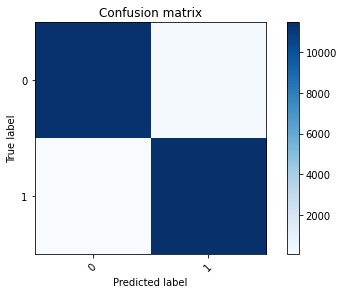

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     11562
           1       0.98      0.99      0.99     11540

    accuracy                           0.99     23102
   macro avg       0.99      0.99      0.99     23102
weighted avg       0.99      0.99      0.99     23102



In [ ]:
#confusion matrix for dense model
dense = confusion_matrix(y_true_dense, pred_dense)
print(dense)
print('Plotting confusion matrix')
plt.figure()
plot_confusion_matrix(dense, outcome_final)
plt.show()
print(classification_report(y_true_dense, pred_dense))